In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/PhD/GaussianProcessNode`


In [2]:
using Revise 
using StableRNGs, GraphPPL,ReactiveMP, RxInfer, Random, Distributions, LinearAlgebra, Plots
using Flux, Zygote, ForwardDiff
using BenchmarkTools
import KernelFunctions: SqExponentialKernel, Matern52Kernel, with_lengthscale, Kernel, kernelmatrix  
# import Functors: @functor

## Prepare data 

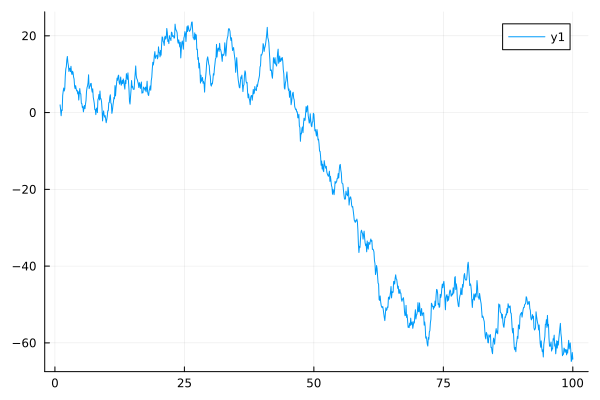

In [116]:
t = collect(1:0.1:100)
x = zeros(length(t))
x[1] = 2.
for i = 2:length(t)
    x[i] = x[i-1] + randn() * 1.2^2
end
plot(t, x)

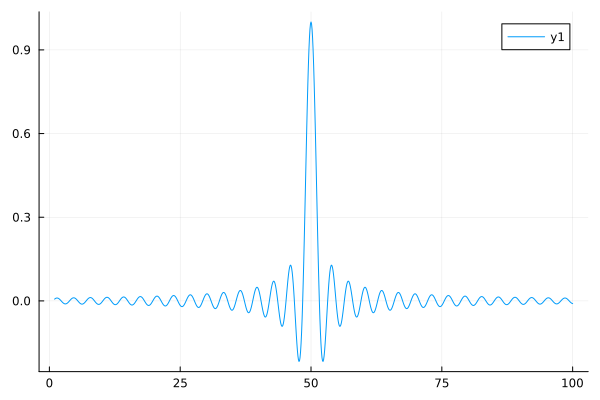

In [117]:
f = sinc.(2π*0.1 * (t .- 50)) ;
plot(t,f)

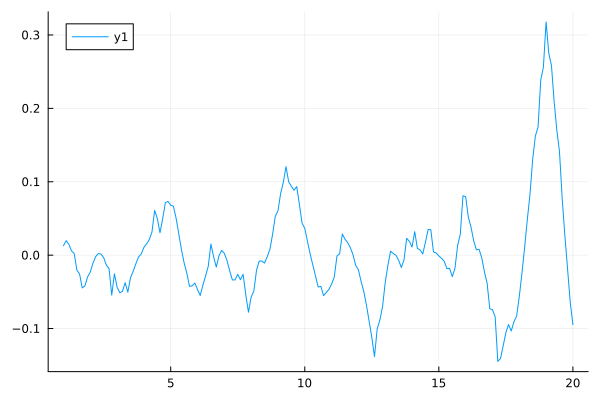

In [79]:
plot(t, x .* f)

In [3]:
function generate_data(n,x_0, f_gp, σ_x, σ_y)
    y=[]
    x = []
    x_prev = x_0
    for i=1:n
        x_t = x_prev + σ_x * randn()
        temp = x_t * f_gp[i]  
        push!(y,temp)
        push!(x,x_t)
        x_prev = x_t      
    end
    return x, y 
end

generate_data (generic function with 1 method)

In [4]:
Random.seed!(12)
σ_x = 0.3
σ_y = 0.2
x_init = 3.

N = 50; #data length
n = 100; #lenght of the axis of gp 
meanf = (x) -> 0.0;
kernel(θ) = with_lengthscale(SqExponentialKernel(),θ)
tmin,tmax = 0.1, 9.
time_range = collect(range(tmin, tmax; length=n));

θ_gp = 1.2
Cov_mat = kernelmatrix(kernel(θ_gp),time_range,time_range) + 1e-8*I;
gp = MvNormal(meanf.(time_range), Cov_mat)
f_test = rand(gp)

#Observe data 
pos = sort(randperm(n)[1:N]); # position where we observe data
time_train = time_range[pos]
f_train = f_test[pos];

In [70]:
f_init = rand(gp)

100-element Vector{Float64}:
 -2.263257620784291
 -2.1497046145990932
 -2.033438289986589
 -1.916127767629675
 -1.7989664998057164
 -1.683825718234337
 -1.5714665007882964
 -1.4632975332002844
 -1.3607766890170256
 -1.2636313208661776
  ⋮
 -1.4844338139468218
 -1.5594640177401686
 -1.6154246933498355
 -1.6527880968782067
 -1.6717728761966217
 -1.6738414702675517
 -1.6600595067557786
 -1.632971384684451
 -1.5947737081187345

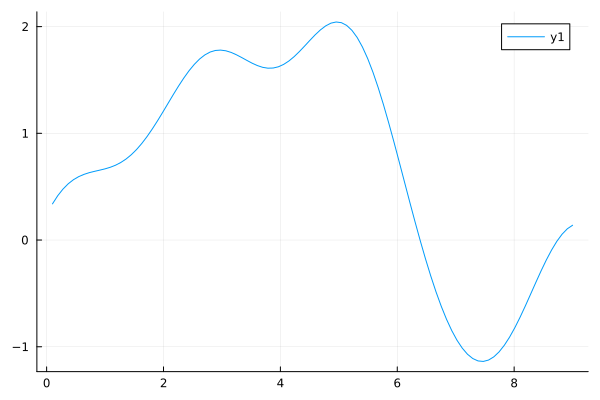

In [5]:
plot(time_range,f_test)

In [6]:
#Generate data 
x_true_state, y_data = generate_data(N,x_init,f_train,σ_x,σ_y);

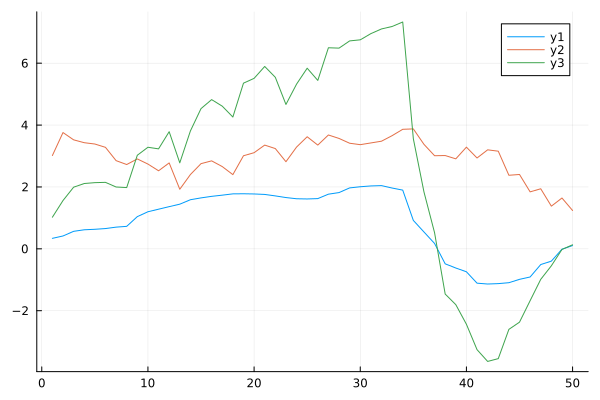

In [7]:
plot(f_train)
plot!(x_true_state)
plot!(y_data)

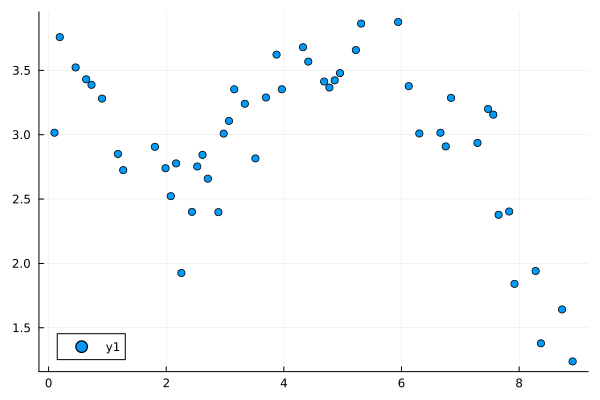

In [8]:
# scatter(time_train, y_data)
scatter(time_train, x_true_state)

## Specify model

In [9]:
#Test with GP with fixed hyperparameters
@model function randomwalk_gp(n, gp_kernel,gp_mean, train,test, gpstrategy, σ_x)
    x = randomvar(n)
    f = randomprocess(test, train, gpstrategy)
    y = datavar(Float64,n)
    h = randomvar(n)

    f ~ GaussianProcess(gp_mean, gp_kernel, log(1.3))
    x_0 ~ NormalMeanVariance(x_init, 50)
    x_prev = x_0 

    for i=1:n 
        x[i] ~ NormalMeanVariance(x_prev,σ_x^2)
        h[i] ~ (*)(x[i],f) where {meta = (ProcessMeta(i),TinyCorrection(),)}
        y[i] ~ NormalMeanPrecision(h[i], 1.5)
        x_prev = x[i]
    end
end

In [10]:
# @constraints function gpconstraints()   
#     q(x_init,x,f,h) = q(x_init)q(x)q(f)q(h)
# end

In [11]:
using SpecialFunctions

In [12]:
cov_strategy = CovarianceMatrixStrategy(FullCovarianceStrategy())

CovarianceMatrixStrategy{FullCovarianceStrategy{Vector{Int64}, Nothing}}(FullCovarianceStrategy{Vector{Int64}, Nothing}(Int64[], nothing, [1.0;;], ReactiveMP.GPCache(Dict{Tuple{Symbol, Tuple{Int64, Int64}}, Matrix{Float64}}(), Dict{Tuple{Symbol, Int64}, Vector{Float64}}())))

In [13]:
# modified Bessel function of second kind 
function besselmod(x,mx,vx,my,vy,m,n) 
    tmp1 = x^(2n-m)*abs(x)^(m-n)*vx^(m-n-1)*(mx/vx)^m*binomial(2n,m)*(my/vy)^(2n-m)*besselk(m-n,abs(x)/sqrt(vx*vy))
    tmp2 = pi*(factorial(2n))*vy^(m-n+1)
    
    return tmp1/tmp2
end

besselmod (generic function with 1 method)

In [62]:
## rule for the edge "A"

@rule typeof(*)(:A, Marginalisation) (m_out::UnivariateGaussianDistributionsFamily, m_in::GaussianProcess, meta::Tuple{ProcessMeta, TinyCorrection}) = begin 
    index = meta[1].index
    m_gp, cov_gp = mean_cov(m_in.finitemarginal)
    kernelf = m_in.kernelfunction
    meanf   = m_in.meanfunction
    test    = m_in.testinput
    train   = m_in.traininput
    cov_strategy = m_in.covariance_strategy
    x_u = m_in.inducing_input
    mμ, var_μ = ReactiveMP.predictMVN(cov_strategy, kernelf,meanf,test,[train[index]],m_gp, x_u) #changed here
    μ_in = mμ[1]
    var_in = abs(var_μ[1])

    # get mean and variance from m_out 
    μ_out, var_out = mean_var(m_out)
    # @show var_in 
    # @show var_out
    function backwardpass(x) 
        # if x==0.0
        #     return logpdf(m_out, 0)
        # else
            return -log(abs(x) ) - 0.5*log( 2π * (abs(var_in) + var_out / x^2)) +  -1/2 * (μ_out / x - μ_in)^2 / (abs(var_in) + var_out / x^2)
        # end
    end 
    @show μ_in, var_in
    @show backwardpass(3)

    return ContinuousUnivariateLogPdf(backwardpass)
end

@rule typeof(*)(:A, Marginalisation) (m_out::UnivariateGaussianDistributionsFamily, m_in::UnivariateGaussianDistributionsFamily, meta::Tuple{ProcessMeta, TinyCorrection}) = begin 
    μ_in, var_in = mean_var(m_in)
    μ_out, var_out = mean_var(m_out)
    function backwardpass(x) 
        # if x ==0.
        #     return logpdf(m_out, 0)
        # else
            return -log(abs(x) ) - 0.5*log( 2π * (abs(var_in) + var_out / x^2)) +  -1/2 * (μ_out / x - μ_in)^2 / (abs(var_in) + var_out / x^2)
        # end
    end 

    return ContinuousUnivariateLogPdf(backwardpass)
end

##rule for the "in" edge, same rule as the edge "A"
@rule typeof(*)(:in, Marginalisation) (m_out::UnivariateGaussianDistributionsFamily, m_A::UnivariateGaussianDistributionsFamily, meta::Tuple{ProcessMeta, TinyCorrection}) = begin 
    return @call_rule typeof(*)(:A, Marginalisation) (m_out = m_out, m_in = m_A, meta = meta)
end


## rule for the edge "out" (we approximate the message as a gaussian. The true form should be the modified Bessel function of second kind)
@rule typeof(*)(:out, Marginalisation) (m_A::UnivariateGaussianDistributionsFamily, m_in::GaussianProcess, meta::Tuple{ProcessMeta, TinyCorrection}) = begin 
    index = meta[1].index
    m_gp, cov_gp = mean_cov(m_in.finitemarginal)
    kernelf = m_in.kernelfunction
    meanf   = m_in.meanfunction
    test    = m_in.testinput
    train   = m_in.traininput
    cov_strategy = m_in.covariance_strategy
    x_u = m_in.inducing_input
    mμ, var_μ = ReactiveMP.predictMVN(cov_strategy, kernelf,meanf,test,[train[index]],m_gp, x_u) #changed here
    μ_in = mμ[1]
    var_in = var_μ[1]

    μ_A, var_A = mean_var(m_A)
    #compute statistics for out 
    # return ContinuousUnivariateLogPdf((x) -> log(sum(sum(besselmod(x,μ_in,var_in,μ_A,var_A,m,n ) for m=0:2n) for n=0:5)))
    return NormalMeanVariance(μ_A * μ_in, μ_A^2 * var_in + μ_in^2 * var_A + var_A * var_in)
end

@rule typeof(*)(:out, Marginalisation) (m_A::UnivariateGaussianDistributionsFamily, m_in::UnivariateGaussianDistributionsFamily, meta::Tuple{ProcessMeta, TinyCorrection}) = begin 
    μ_in, var_in = mean_var(m_in)
    μ_A, var_A = mean_var(m_A)
    # return ContinuousUnivariateLogPdf((x) -> log(sum(sum(besselmod(x,μ_in,var_in,μ_A,var_A,m,n) for m=0:2n) for n=0:5)))
    return NormalMeanVariance(μ_A * μ_in, μ_A^2 * var_in + μ_in^2 * var_A + var_A * var_in)
end


In [63]:
sum(sum(besselmod(.1,3.,2.,1.,4.,m,n) for m=0:2n) for n=0:5)

0.2687274466445931

In [64]:
using ForwardDiff, Optim

In [65]:
@rule NormalMeanPrecision(:μ, Marginalisation) (q_out::PointMass, m_τ::GammaShapeRate, ) = begin 
    return @call_rule NormalMeanPrecision(:μ, Marginalisation) (q_out = q_out, q_τ = m_τ)
end
@rule NormalMeanPrecision(:τ, Marginalisation) (q_out::PointMass, m_μ::NormalMeanVariance, ) = begin 
    return @call_rule NormalMeanPrecision(:τ, Marginalisation) (q_out = q_out, q_μ = m_μ)
end


In [66]:
@rule NormalMeanVariance(:μ, Marginalisation) (m_out::ContinuousUnivariateLogPdf, q_v::PointMass, ) = begin 
    res = optimize(x -> -logpdf(m_out,x), -10,10)
    m0 = res.minimizer
    v0 = cholinv(hessian(x -> -logpdf(m_out,x), m0[1]))
    # v0 = 0.1
    # d0 = NormalMeanVariance(m0[1],v0[1])
    # l_pdf(x) = logpdf(m_out,x) - logpdf(d0,x)
    # meta = GaussHermiteCubature(71)
    # @show m,v = ReactiveMP.approximate_meancov(meta, z -> exp(l_pdf(z)), m0[1], v0[1])
    d = NormalMeanVariance(m0[1],v0[1])

    return @call_rule NormalMeanVariance(:μ, Marginalisation) (m_out=d, q_v=q_v)
end

In [67]:
import ReactiveMP: GaussHermiteCubature

In [68]:
#use Gaussian GaussHermiteCubature to approximate 
#Temporarily put here 
function ReactiveMP.prod(::ProdAnalytical, left::UnivariateGaussianDistributionsFamily, right::ContinuousUnivariateLogPdf) 
    #we use Gaussian Hermite Cubature here, not ProdAnalytical 
    meta = GaussHermiteCubature(71)
    m,v = ReactiveMP.approximate_meancov(meta, z -> exp(right.logpdf(z)), mean(left), cov(left))
    return NormalMeanVariance(m,v)
end

function ReactiveMP.prod(::ProdAnalytical, left::ContinuousUnivariateLogPdf, right::UnivariateGaussianDistributionsFamily)
    meta = GaussHermiteCubature(71)
    m,v = ReactiveMP.approximate_meancov(meta, z -> exp(left.logpdf(z)), mean(right), var(right))
    return NormalMeanVariance(m,v)
end

function Distributions.mean(p::ContinuousUnivariateLogPdf)
    res = optimize(x -> -logpdf(p,x),-10,10)
    m0 = res.minimizer
    return m0[1]
end

function Distributions.var(p::ContinuousUnivariateLogPdf)
    res = optimize(x -> -logpdf(p,x), -10,10)
    m0 = res.minimizer
    dx = (x) -> ForwardDiff.derivative(p.logpdf,x)
    ddx = (x) -> ForwardDiff.derivative(dx,x)
    p.logpdf(3)
    return -cholinv(ddx(m0[1]))
end

In [71]:
nits = 10
iresult = inference(
    model = randomwalk_gp(length(y_data), kernel, meanf, time_train,time_range, cov_strategy, σ_x),
    initmessages = (x_0 = NormalMeanVariance(2, 1.2),f = GaussianProcess(meanf,kernel(1.5),MvNormalMeanCovariance(f_init,Cov_mat),time_range,time_train,Float64[], CovarianceMatrixStrategy(FullCovarianceStrategy())),),
    iterations = nits,  
    data  = (y = y_data,),
    free_energy = false
)

(μ_in, var_in) = (1727.161089821161, 1443.307437221826)
backwardpass(3) = -1038.614340096628
(μ_in, var_in) = (1801.799637448049, 1166.797955421719)
backwardpass(3) = -1395.8497450963964
(μ_in, var_in) = (2006.763515279514, 1535.936038842736)
backwardpass(3) = -1315.7147895458888
(μ_in, var_in) = (2121.9520428053424, 1593.1543606715009)
backwardpass(3) = -1417.8353793139236
(μ_in, var_in) = (2171.5553411587052, 1373.9853613037178)
backwardpass(3) = -1720.4603739141874
(μ_in, var_in) = (2252.6749366135527, 1377.784636111607)
backwardpass(3) = -1845.921323223943
(μ_in, var_in) = (2325.4354901483575, 1715.9262566857542)
backwardpass(3) = -1580.4942697354168
(μ_in, var_in) = (2336.1690454325935, 1056.470512062542)
backwardpass(3) = -2586.8397372097015
(μ_in, var_in) = (2255.0456455143626, 1137.7550616730841)
backwardpass(3) = -2238.157985519106
(μ_in, var_in) = (2169.010031475167, 793.243998046473)
backwardpass(3) = -2967.5084401675776
(μ_in, var_in) = (2114.0462990236224, 603.617218252646

(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN


NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = 

(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN
(μ_in, var_in) = (NaN, NaN)
backwardpass(3) = NaN


Inference results:
  Posteriors       | available for (f, x_0, h, x)


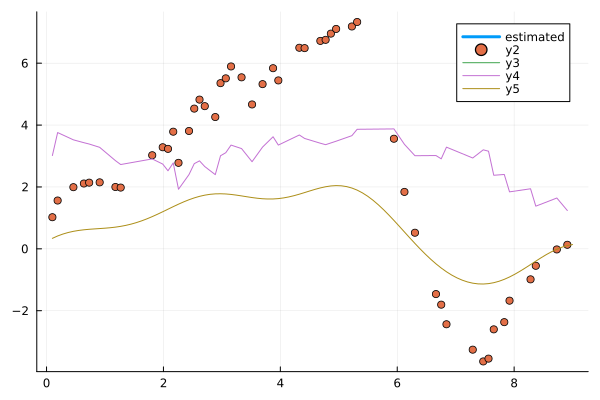

In [33]:
plot(time_range,mean(iresult.posteriors[:f][end].finitemarginal),ribbon=sqrt.(diag(cov(iresult.posteriors[:f][end].finitemarginal))),linewidth=3.0,label="estimated",fillalpha=0.3)
scatter!(time_train,y_data)
plot!(time_train,mean.(iresult.posteriors[:x][end]))
plot!(time_train,x_true_state)
plot!(time_range, f_test)


In [164]:
iresult.posteriors[:h]

11-element Vector{Vector{NormalWeightedMeanPrecision{Float64}}}:
 [NormalWeightedMeanPrecision{Float64}(xi=3.085842179298158, w=1.3000004445939806), NormalWeightedMeanPrecision{Float64}(xi=3.4777911153242043, w=1.3000005804463273), NormalWeightedMeanPrecision{Float64}(xi=-0.8808990710300654, w=1.3000005545601587), NormalWeightedMeanPrecision{Float64}(xi=-3.0085095678576472, w=1.300000533237979), NormalWeightedMeanPrecision{Float64}(xi=-4.349794568182084, w=1.3000005161627883), NormalWeightedMeanPrecision{Float64}(xi=2.6574756848847803, w=1.300000502957845), NormalWeightedMeanPrecision{Float64}(xi=3.2807317333529453, w=1.3000004931756592), NormalWeightedMeanPrecision{Float64}(xi=0.3552127607804861, w=1.3000004868431458), NormalWeightedMeanPrecision{Float64}(xi=-0.09761907726695257, w=1.3000004836977097), NormalWeightedMeanPrecision{Float64}(xi=3.40197242099403, w=1.300000483762386)  …  NormalWeightedMeanPrecision{Float64}(xi=-3.7008867046078864, w=1.3008673834696571), NormalWeightedMean

In [199]:
q_x = iresult.posteriors[:x];
x_pos = [mean.(q_x[i]) for i=1:nits]

9-element Vector{Vector{Float64}}:
 [-0.007976818684471225, -0.00729846343477309, -0.0064439581844440465, -0.007123641229280867, -0.005892656468870103, -0.00583530027333929, -0.006714346995762743, -0.00559095646037988, -0.005161748599816495, -0.005346557304948966  …  0.2003978034564218, 0.2270589759280674, 0.2985084288321067, 0.24379659662443562, 0.20775371198885564, 0.2673034563226154, 0.3160641290068641, 0.26825870937135565, 0.33096146767154005, 0.5135471808098445]
 [8.562553792299035, 9.02047277089929, 9.478461132421895, 9.936524047639486, 10.394650489711253, 10.852848360112905, 11.311112569327534, 11.769429046413022, 12.22780121270834, 12.686225626006236  …  2.9062785470941477, 3.04174255767665, 3.3534633694397122, 2.6434050975088534, 2.2173491210588407, 2.2626088411977316, 2.3778260669703006, 2.1612289455306355, 2.4847763890845447, 3.7253707511927394]
 [0.0038700754432353804, 0.0039851140892780395, 0.004049103093377983, 0.005308589409813147, 0.005438827680235447, 0.007144456717953

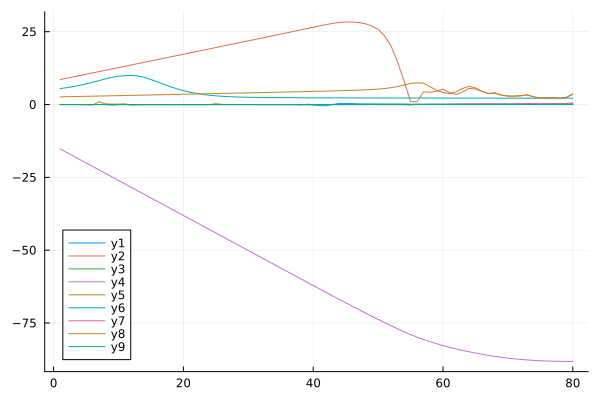

In [200]:
plot(x_pos)